In [1]:
using DataFrames # Requires > 0.22.0 for rownums function
using CSV
using Statistics
using LinearAlgebra
using Plots
using StatsBase
using Distributions
using MLJ
using MLJLinearModels
using MLJXGBoostInterface
using XGBoost
import MLJBase: train_test_pairs

# Using for Logistic + CV options, also as an example of how to use Sklearn within Julia
using ScikitLearn

@sk_import linear_model: (LogisticRegression, LinearRegression)
@sk_import model_selection: (TimeSeriesSplit, KFold, GroupKFold, cross_val_score)
@sk_import metrics: make_scorer

┌ Warning: Module model_selection has been ported to Julia - try `import ScikitLearn: CrossValidation` instead
└ @ ScikitLearn.Skcore C:\Users\Justin\.julia\packages\ScikitLearn\ssekP\src\Skcore.jl:179


PyObject <function make_scorer at 0x000000008F07CA60>

In [2]:
df = CSV.File("numerai_training_data.csv") |> DataFrame

first(df,5)

,id,era,data_type,feature_intelligence1,feature_intelligence2
,String,String,String,Float64,Float64
1,n000315175b67977,era1,train,0.0,0.5
2,n0014af834a96cdd,era1,train,0.0,0.0
3,n001c93979ac41d4,era1,train,0.25,0.5
4,n0034e4143f22a13,era1,train,1.0,0.0
5,n00679d1a636062f,era1,train,0.25,0.25


In [3]:
# There are 501808 rows grouped into eras, and a single target (target)

size(df)

(501808, 314)

In [4]:
features = select(df, r"feature") |> names
df.erano = parse.(Int64, replace.(df.era, "era" => ""))
eras = df.erano
target = "target"
length(features)

310

In [5]:
# The features are grouped together into 6 types
feature_groups =
    Dict(g => [c for c in features if startswith(c, "feature_$g")] 
        for g in ["intelligence", "wisdom", "charisma", "dexterity", "strength", "constitution"])

Dict{String, Vector{String}} with 6 entries:
  "charisma"     => ["feature_charisma1", "feature_charisma2", "feature_charism…
  "constitution" => ["feature_constitution1", "feature_constitution2", "feature…
  "dexterity"    => ["feature_dexterity1", "feature_dexterity2", "feature_dexte…
  "wisdom"       => ["feature_wisdom1", "feature_wisdom2", "feature_wisdom3", "…
  "strength"     => ["feature_strength1", "feature_strength2", "feature_strengt…
  "intelligence" => ["feature_intelligence1", "feature_intelligence2", "feature…

In [6]:
# The models should be scored based on the rank-correlation (spearman) with the target
# There's probably (definitely) a better way to write this - [ordinalrank would solve the ranking]

function numerai_score(y_true, y_pred, df)
        rank_pred = sort(combine(groupby(DataFrame(y_pred = y_pred
                                , eras = df.erano
                                , rnum = rownumber.(eachrow(df)))
                        , :eras)
                , sdf -> sort(sdf, :y_pred)
                , :eras => eachindex => :rank
                , nrow => :n)
            , :rnum)

        rank_pred = rank_pred.rank ./ rank_pred.n
    
        cor(y_true, rank_pred)
    end

# It can also be convenient while working to evaluate based on the regular (pearson) correlation
# R2 Score to replicate the Python library outputs

function r2_score(y_true, y_pred)
    @assert length(y_true) == length(y_pred)
    ss_res = sum((y_true .- y_pred).^2)
    mean = sum(y_true) / length(y_true)
    ss_total = sum((y_true .- mean).^2)
    return 1 - ss_res/(ss_total + eps(eltype(y_pred)))
end

# cor() returns a matrix with no need for manipulation, so no need to replicate that here

r2_score (generic function with 1 method)

In [7]:
# There are 120 eras numbered from 1 to 120

describe(df, :all, cols=:erano)

,variable,mean,std,min,q25,median,q75,max,nunique,nmissing
,Symbol,Float64,Float64,Int64,Float64,Float64,Float64,Int64,Nothing,Int64
1,erano,64.002,33.3329,1,37.0,64.0,93.0,120,,0


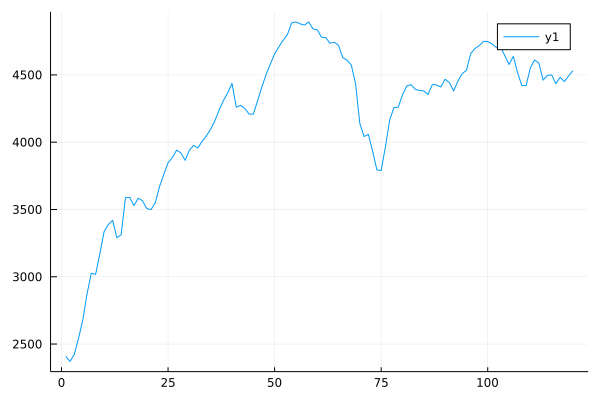

In [8]:
# The earlier eras are smaller, but generally each era is 4000-5000 rows

group_df = combine(groupby(df, :erano), nrow => :count)
plot(group_df.erano, group_df.count)

In [9]:
# The target is discrete and takes on 5 different values

combine(groupby(df, :target), nrow => :count)

,target,count
,Float64,Int64
1,0.5,251677
2,0.25,100053
3,0.75,100045
4,0.0,25016
5,1.0,25017


# Some of the features are very correlated
Especially within feature groups

In [10]:
feature_corrs = DataFrame(cor(Matrix(df[!, names(df, features)])), features)
insertcols!(feature_corrs, 1, :features => features)

first(feature_corrs,5)

,features,feature_intelligence1,feature_intelligence2,feature_intelligence3
,String,Float64,Float64,Float64
1,feature_intelligence1,1.0,-0.0141565,-0.0244041
2,feature_intelligence2,-0.0141565,1.0,0.905315
3,feature_intelligence3,-0.0244041,0.905315,1.0
4,feature_intelligence4,0.652596,-0.0280969,-0.0410859
5,feature_intelligence5,0.0698683,0.184372,0.17387


In [11]:
first(stack(feature_corrs), 5)

,features,variable,value
,String,String,Float64
1,feature_intelligence1,feature_intelligence1,1.0
2,feature_intelligence2,feature_intelligence1,-0.0141565
3,feature_intelligence3,feature_intelligence1,-0.0244041
4,feature_intelligence4,feature_intelligence1,0.652596
5,feature_intelligence5,feature_intelligence1,0.0698683


In [12]:
tdf = stack(feature_corrs)
tdf = tdf[coalesce.(tdf.variable .< tdf.features, false), :]

sort!(tdf, :value)
vcat(first(tdf, 5), last(tdf, 5))

,features,variable,value
,String,String,Float64
1,feature_constitution9,feature_constitution112,-0.855008
2,feature_constitution46,feature_constitution33,-0.83031
3,feature_constitution60,feature_constitution112,-0.820694
4,feature_constitution87,feature_constitution46,-0.815888
5,feature_constitution33,feature_constitution112,-0.759084
6,feature_constitution7,feature_constitution27,0.94892
7,feature_constitution79,feature_constitution13,0.949139
8,feature_wisdom39,feature_wisdom31,0.954984
9,feature_wisdom7,feature_wisdom46,0.963706


### The correlation can change over time
You can see this by comparing feature correlations on the first half and second half on the training set

In [13]:
df₁ = df[coalesce.(eras .<= median(eras), false), :]
df₂ = df[coalesce.(eras .> median(eras), false), :]

corr₁ = DataFrame(cor(Matrix(df₁[!, names(df₁, features)])), features)
insertcols!(corr₁, 1, :features => features)
corr₁ = stack(corr₁)
corr₁ = corr₁[coalesce.(corr₁.variable .< corr₁.features, false), :]

corr₂ = DataFrame(cor(Matrix(df₂[!, names(df₂, features)])), features)
insertcols!(corr₂, 1, :features => features)
corr₂ = stack(corr₂)
corr₂ = corr₂[coalesce.(corr₂.variable .< corr₂.features, false), :]

tdf = leftjoin(corr₁, corr₂, on = [:variable, :features], makeunique=true)
rename!(tdf, [:value, :value_1] .=> [:corr₁, :corr₂])
tdf.corr_diff = tdf.corr₂ - tdf.corr₁
sort!(tdf, :corr_diff)

vcat(first(tdf,5), last(tdf,5))

,features,variable,corr₁,corr₂,corr_diff
,String,String,Float64,Float64?,Float64
1,feature_intelligence9,feature_intelligence11,0.0913519,-0.128851,-0.220203
2,feature_intelligence10,feature_dexterity12,0.548931,0.343117,-0.205814
3,feature_intelligence11,feature_dexterity9,0.0787148,-0.12707,-0.205785
4,feature_dexterity12,feature_dexterity1,0.653528,0.447942,-0.205587
5,feature_intelligence11,feature_intelligence10,0.0750222,-0.130511,-0.205534
6,feature_wisdom22,feature_intelligence8,-0.0883461,0.117772,0.206119
7,feature_wisdom43,feature_intelligence4,-0.102438,0.103758,0.206197
8,feature_wisdom33,feature_intelligence4,-0.0789296,0.133664,0.212593
9,feature_wisdom43,feature_intelligence8,-0.121306,0.115194,0.236501


## Some features are predictive on their own

In [14]:
feature_scores = 
    Dict(feature => numerai_score(df.target, df[!, feature], df) 
    for feature in features);

In [15]:
sort(collect(feature_scores), by=x->x[2])

310-element Vector{Pair{String, Float64}}:
      "feature_dexterity7" => -0.011504914975281387
      "feature_dexterity6" => -0.011161569760516648
      "feature_dexterity4" => -0.011051275935746707
      "feature_charisma69" => -0.010221311263804505
     "feature_dexterity11" => -0.010198611285978189
       "feature_charisma9" => -0.01005025481510148
     "feature_dexterity12" => -0.008647990681418269
     "feature_dexterity14" => -0.008611934226827449
      "feature_dexterity3" => -0.007607475423078082
  "feature_constitution91" => -0.007343474478571397
      "feature_dexterity8" => -0.0072798010318430835
  "feature_constitution56" => -0.007206474137472462
 "feature_constitution110" => -0.007154545491821277
                           ⋮
       "feature_strength4" => 0.010184232051437234
      "feature_charisma81" => 0.010224703123621929
      "feature_charisma46" => 0.01039946229179084
      "feature_charisma66" => 0.010507207995266913
      "feature_charisma54" => 0.01050761493183076

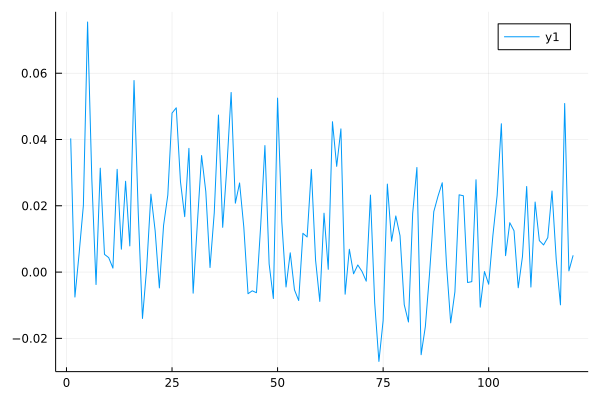

In [16]:
# Single features do not work consistently though

by_era_correlation = 
    sort(Dict(values(erano)[1] => cor(tdf.target, tdf.feature_strength34)
         for (erano, tdf) in pairs(groupby(df, :erano))))
    
plot(by_era_correlation)

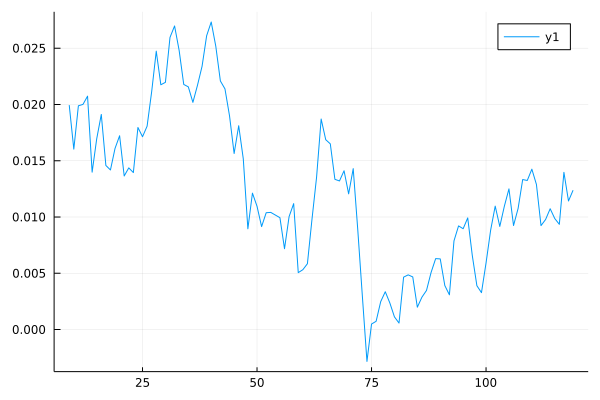

In [17]:
# With a rolling 10 era average you can see some trends

function rolling_mean(arr, n)
    rs = cumsum(arr)[n:end] .- cumsum([0.0; arr])[1:end-n]
    return rs ./ n
end

n_window = 10

plot(Dict(zip(collect(n_window-1:length(by_era_correlation)), 
        rolling_mean(collect(values(by_era_correlation)),n_window))))

# Gotcha: MSE looks worse than correlation out of sample
Models will generally be overconfident, so even if they are good at ranking rows, the Mean-Squared-Error of the residuals could be larger than event the Mean-Squared-Error of the target (r-squared<0)

In [18]:
df₁ = df[coalesce.(eras .<= median(eras), false), :]
df₂ = df[coalesce.(eras .> median(eras), false), :];

In [19]:
# This is using MLJ, Julia's homegrown machine-learning library

Linear = @load LinearRegressor pkg=MLJLinearModels verbosity=0
linear = Linear()

lin₁ = machine(linear, df₁[!, names(df₁, features)], df₁.target)
MLJ.fit!(lin₁, verbosity=0)

lin₂ = machine(linear, df₂[!, names(df₂, features)], df₂.target)
MLJ.fit!(lin₂, verbosity=0);

In [20]:
# Note in particular that the R-squared of (train_on_1, eval_on_2) is slightly negative!

r2₁ = [
    r2_score(dfₓ.target, MLJ.predict(model, dfₓ[!, names(dfₓ, features)]))
        for dfₓ in [df₁, df₂]
    for model in [lin₁, lin₂]]

DataFrame(reshape(r2₁, 2, 2), ["eval_on_1","eval_on_2"])

,eval_on_1,eval_on_2
,Float64,Float64
1,0.00409275,-0.000543157
2,0.000574622,0.00315522


In [21]:
# Note in particular that the correlation of (train_on_1, eval_on_2) is quite decent (comparatively)
corrs = [
    numerai_score(MLJ.predict(model, dfₓ[!, names(dfₓ, features)]), dfₓ.target, dfₓ)
        for dfₓ in [df₁, df₂]
    for model in [lin₁, lin₂]]

DataFrame(reshape(corrs, 2, 2), ["eval_on_1","eval_on_2"])

,eval_on_1,eval_on_2
,Float64,Float64
1,0.058282,0.0287217
2,0.0319412,0.0528229


In [22]:
# This can be be run with XGB as well

XGB = @load XGBoostRegressor pkg=XGBoost verbosity=0
xgb = XGB()

xgb₁ = machine(xgb, df₁[!, names(df₁, features)], df₁.target)
MLJ.fit!(xgb₁, verbosity=0)

xgb₂ = machine(xgb, df₂[!, names(df₂, features)], df₂.target)
MLJ.fit!(xgb₂, verbosity=0);

In [23]:
r2₂ = [
    r2_score(dfₓ.target, MLJ.predict(model, dfₓ[!, names(dfₓ, features)]))
        for dfₓ in [df₁, df₂]
    for model in [xgb₁, xgb₂]]

DataFrame(reshape(r2₂, 2, 2), ["eval_on_1","eval_on_2"])

,eval_on_1,eval_on_2
,Float64,Float64
1,0.123117,-0.0237936
2,-0.0199959,0.12788


In [24]:
corrs2 = [
    numerai_score(MLJ.predict(model, dfₓ[!, names(dfₓ, features)]), dfₓ.target, dfₓ)
        for dfₓ in [df₁, df₂]
    for model in [xgb₁, xgb₂]]

DataFrame(reshape(corrs2, 2, 2), ["eval_on_1","eval_on_2"])

,eval_on_1,eval_on_2
,Float64,Float64
1,0.383874,0.0240443
2,0.0229365,0.392287


# Gotcha:  {0, 1} are noticeably different from {0.25, 0.75}
This makes training a classifier one-versus-rest behave counterintuitively.

Specifically, the 0-vs-rest and 1-vs-rest classifiers seem to learn how to pick out extreme targets, and their predictions are the most correlated

In [25]:
# Mostly doing this in Scikitlearn.JL due to no predict_proba (that I'm aware of) in MLJ

logistic = LogisticRegression()
ScikitLearn.fit!(logistic, Matrix(df[!, names(df, features)]), convert.(Int, df.target*4))
ScikitLearn.score(logistic, Matrix(df[!, names(df, features)]), convert.(Int, df.target*4))

C:\Users\Justin\.julia\conda\3\lib\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


0.5012315467270351

5×5 Matrix{Float64}:
  1.0        0.468155  -0.903881   0.42197    0.947252
  0.468155   1.0       -0.704718   0.517207   0.428423
 -0.903881  -0.704718   1.0       -0.71843   -0.914418
  0.42197    0.517207  -0.71843    1.0        0.498854
  0.947252   0.428423  -0.914418   0.498854   1.0

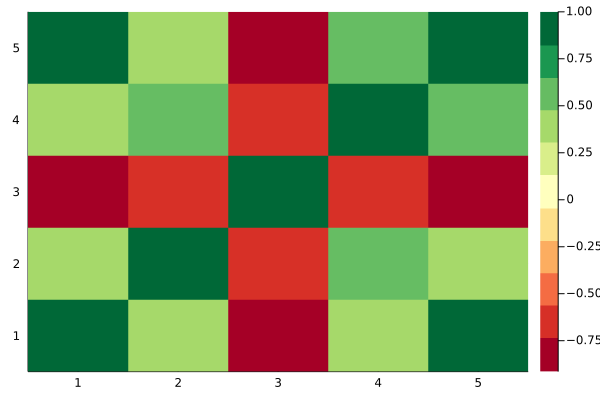

In [26]:
# The first and last class are highly correlated
log_corrs = cor(transpose(ScikitLearn.predict_proba(logistic, Matrix(df[!, names(df, features)]))), dims=2)
display(log_corrs)

heatmap(log_corrs,  c=palette(:RdYlGn))

In [27]:
# In-sample correlation

prob_matrix = ScikitLearn.predict_proba(logistic, Matrix(df[!, names(df, features)]))
classes = logistic.classes_
numerai_score(df.target, prob_matrix * classes, df)

0.050658929537343786

In [28]:
# A standard linear model has a slightly higher correlation
linear = LinearRegression()
ScikitLearn.fit!(linear, Matrix(df[!, names(df, features)]), df.target)
ScikitLearn.score(linear, Matrix(df[!, names(df, features)]), df.target)
preds = ScikitLearn.predict(linear, Matrix(df[!, names(df, features)]))
numerai_score(df.target, preds, df)

0.05107803901831943

# Gotcha: eras are homogenous, but different from each other
##  Random cross-validation will look much better than cross-validating by era

Even for a simple linear model, taking a random shuffle reports a correlation of 4.3%, but a time series split reports a lower score of 3.4%

In [29]:
#linear = LinearRegression()
#ScikitLearn.fit!(linear, Matrix(df[!, names(df, features)]), df.target)

In [30]:
crossvalidators = [KFold(5), KFold(5, shuffle = true), GroupKFold(5), TimeSeriesSplit(5)]

for cv in crossvalidators
    println(cv)
    println(
        mean(
            cross_val_score(estimator = LinearRegression(),
                X = Matrix(df[!, names(df, features)]),
                y = df.target,
                cv = cv,
                groups = eras,
                scoring = make_scorer(cor, greater_is_better = true)
            )
        )
    )
end

PyObject KFold(n_splits=5, random_state=None, shuffle=False)
0.03332624500455265
PyObject KFold(n_splits=5, random_state=None, shuffle=True)
0.039196207369748895
PyObject GroupKFold(n_splits=5)
0.03475937229926111
PyObject TimeSeriesSplit(gap=0, max_train_size=None, n_splits=5, test_size=None)
0.030947709608331396


## Eras can be more or less applicable to other eras
You can test this be splitting the eras into blocks of 10, training on each block, and evaluating on each other block.

In [31]:
eras10 = (eras .÷ 10) * 10
countmap(eras10)

Dict{Int64, Int64} with 13 entries:
  20  => 37444
  110 => 45070
  60  => 46831
  30  => 41101
  0   => 24515
  80  => 43971
  90  => 45609
  40  => 43439
  70  => 40403
  50  => 48186
  10  => 34600
  120 => 4532
  100 => 46107

In [32]:
gdf = copy(df)
gdf[:, :eras10 ] = eras10
gdf = groupby(filter(row -> row[:eras10] < 120, gdf), :eras10);
results10 = DataFrame(train_era = Int32[], test_era = Int32[], value = Float32[])

for train_era in keys(gdf)
    
    println(train_era[1])
    
    gdf₁ = gdf[train_era]
    model = LinearRegression()
    ScikitLearn.fit!(model, Matrix(gdf₁[!, names(gdf₁, features)]), gdf₁.target)
    
    for test_era in keys(gdf)
        
        gdf₂ = gdf[test_era]
        
        push!(results10, [train_era[1], 
                         test_era[1], 
                         cor(gdf₂.target, ScikitLearn.predict(model, Matrix(gdf₂[!, names(gdf₂, features)])))])
    end
end

0
10
20
30
40
50
60
70
80
90
100
110


In [33]:
results_df = unstack(results10, :test_era, :value)

,train_era,0,10,20,30,40,50
,Int32,Float32?,Float32?,Float32?,Float32?,Float32?,Float32?
1,0,0.14615,0.0321283,0.0354025,0.0287675,0.0221984,0.00701235
2,10,0.0421759,0.114813,0.0287059,0.0298504,0.0336937,0.00471899
3,20,0.0431496,0.0334976,0.113055,0.0366226,0.0167489,0.00565709
4,30,0.0357169,0.0339307,0.0396031,0.109884,0.0402888,0.0208269
5,40,0.035735,0.0417183,0.0204626,0.0403498,0.100257,0.0144214
6,50,0.015032,0.00959667,0.00685722,0.0242685,0.0151326,0.104185
7,60,0.00690366,0.0159851,0.00419466,0.0195585,0.012405,0.00967648
8,70,0.034285,0.0252239,0.0220385,0.0285308,0.0232155,0.00198308
9,80,0.0395826,0.0268682,0.0115186,0.0217091,0.0177472,0.00252007


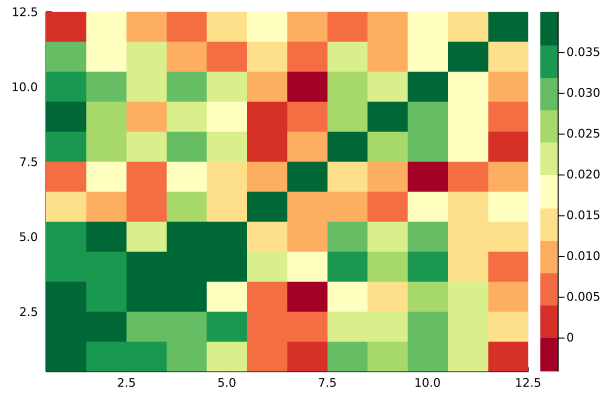

In [34]:
heatmap(clamp!(Matrix(select(results_df, Not(:train_era))), -.04, .04),  c=palette(:RdYlGn))

Here is an advanced paper that talks about generalization.
Eras can be thought about in the same way that "distributions" or "environments" are talked about here
https://arxiv.org/pdf/1907.02893.pdf

## Gotcha: Since the signal-to-noise ratio is so low, models can take many more iterations than expected, and have scarily high in-sample performance

In [35]:
df₁ = df[coalesce.(eras .<= median(eras), false), :]
df₂ = df[coalesce.(eras .> median(eras), false), :];

In [36]:
function our_score(preds, dtrain)
    return "score", cor(get_info(dtrain, "label"), preds)
end

dtrain = DMatrix(Matrix(df₁[!, features]), label=df₁.target)
dtest = DMatrix(Matrix(df₂[!, features]), label=df₂.target)
dall = DMatrix(Matrix(df[!, features]), label=df.target);

In [37]:
# This part I wasn't abel to replicate perfectly, XGBoost on Julia seems to(?) lack an evals_result to push the data into
# the source code shows only that it prints to stderr - one could redirect it to an IOBuffer and regex parse it into an
# array but realistically the amount of effort isn't worth it, since one can clearly see the out-of-sample performance 
# differneces purely from the numbers printed

param = Dict(
    "eta" => 0.1,
    "max_depth" => 3,
    "objective" => "reg:squarederror",
    "eval_metric" => "rmse"
)


xgboost(dtrain,
    100,
    param = param, 
    watchlist = [(dtrain, "train"), (dtest, "test")], 
    feval = our_score
)

[1]	train-score:0.034205	test-score:0.013370
[2]	train-score:0.042116	test-score:0.018210
[3]	train-score:0.044523	test-score:0.020057
[4]	train-score:0.046625	test-score:0.020591
[5]	train-score:0.047456	test-score:0.021075
[6]	train-score:0.050244	test-score:0.022334
[7]	train-score:0.053165	test-score:0.023862
[8]	train-score:0.053749	test-score:0.024308
[9]	train-score:0.055734	test-score:0.025105
[10]	train-score:0.056863	test-score:0.025744
[11]	train-score:0.057717	test-score:0.025711
[12]	train-score:0.058456	test-score:0.026579
[13]	train-score:0.059670	test-score:0.027121
[14]	train-score:0.061333	test-score:0.027169
[15]	train-score:0.062278	test-score:0.027445
[16]	train-score:0.063603	test-score:0.028017
[17]	train-score:0.063934	test-score:0.028256
[18]	train-score:0.065052	test-score:0.028822
[19]	train-score:0.066291	test-score:0.029125
[20]	train-score:0.067134	test-score:0.028689
[21]	train-score:0.068495	test-score:0.029119
[22]	train-score:0.069201	test-score:0.0290

Booster(Ptr{Nothing} @0x000000018aa6a970)

# The results are sensitive to the choice of parameters, which should be picked through cross-validation

In [38]:
df₁ = df[coalesce.(eras .<= median(eras), false), :]
df₂ = df[coalesce.(eras .> median(eras), false), :];

In [39]:
XGB = @load XGBoostRegressor pkg=XGBoost verbosity=0
Linear = @load LinearRegressor pkg=MLJLinearModels verbosity=0
Elastic = @load ElasticNetRegressor pkg=MLJLinearModels verbosity=0

ElasticNetRegressor

In [40]:
models = vcat(
    [Linear()],
    [Elastic(lambda = λ) for λ in [0.01, 0.005, 0.002, 0.001, 0.0005, 0.0002, 0.0001, 0.00005, 0.00002, 0.00001]],
    [XGB()],
    [XGB(eta = 0.01, num_round=1000)],
    [XGB(eta = 0.01, colsample_bytree=0.1, num_round=1000)],
    [XGB(eta = 0.01, colsample_bytree=0.1, num_round=1000, max_depth=5)],
    [XGB(eta = 0.001, colsample_bytree=0.1, num_round=1000, max_depth=5)]
);

In [41]:
for model in models
    print(" -- ", model, "\n")
    mach = machine(model, df₁[!, features], df₁.target)
    MLJ.fit!(mach, verbosity=0)
    outsample = numerai_score(df₂.target, MLJ.predict(mach, df₂[!, features]), df₂)
    insample = numerai_score(df₁.target, MLJ.predict(mach, df₁[!, features]), df₁)
    print("outsample: $outsample, insample: $insample", "\n")
end

 -- LinearRegressor @423
outsample: 0.028025599207339144, insample: 0.06275168899240204
 -- ElasticNetRegressor @297


┌ Warning: Proximal GD did not converge in 1000 iterations.
└ @ MLJLinearModels C:\Users\Justin\.julia\packages\MLJLinearModels\KE4EE\src\fit\proxgrad.jl:64


outsample: 0.027651106932304964, insample: 0.061801048380003165
 -- ElasticNetRegressor @124


┌ Warning: Proximal GD did not converge in 1000 iterations.
└ @ MLJLinearModels C:\Users\Justin\.julia\packages\MLJLinearModels\KE4EE\src\fit\proxgrad.jl:64


outsample: 0.027651115862462477, insample: 0.061800987594603896
 -- ElasticNetRegressor @012


┌ Warning: Proximal GD did not converge in 1000 iterations.
└ @ MLJLinearModels C:\Users\Justin\.julia\packages\MLJLinearModels\KE4EE\src\fit\proxgrad.jl:64


outsample: 0.02765108322778513, insample: 0.06180104261606859
 -- ElasticNetRegressor @994


┌ Warning: Proximal GD did not converge in 1000 iterations.
└ @ MLJLinearModels C:\Users\Justin\.julia\packages\MLJLinearModels\KE4EE\src\fit\proxgrad.jl:64


outsample: 0.027651162275441423, insample: 0.061801053881855784
 -- ElasticNetRegressor @306


┌ Warning: Proximal GD did not converge in 1000 iterations.
└ @ MLJLinearModels C:\Users\Justin\.julia\packages\MLJLinearModels\KE4EE\src\fit\proxgrad.jl:64


outsample: 0.027651155706182137, insample: 0.06180105710588575
 -- ElasticNetRegressor @576


┌ Warning: Proximal GD did not converge in 1000 iterations.
└ @ MLJLinearModels C:\Users\Justin\.julia\packages\MLJLinearModels\KE4EE\src\fit\proxgrad.jl:64


outsample: 0.027651162860262833, insample: 0.06180104657865728
 -- ElasticNetRegressor @704


┌ Warning: Proximal GD did not converge in 1000 iterations.
└ @ MLJLinearModels C:\Users\Justin\.julia\packages\MLJLinearModels\KE4EE\src\fit\proxgrad.jl:64


outsample: 0.0276511455748371, insample: 0.061801044145696406
 -- ElasticNetRegressor @652


┌ Warning: Proximal GD did not converge in 1000 iterations.
└ @ MLJLinearModels C:\Users\Justin\.julia\packages\MLJLinearModels\KE4EE\src\fit\proxgrad.jl:64


outsample: 0.02765113464601516, insample: 0.061801044145696406
 -- ElasticNetRegressor @867


┌ Warning: Proximal GD did not converge in 1000 iterations.
└ @ MLJLinearModels C:\Users\Justin\.julia\packages\MLJLinearModels\KE4EE\src\fit\proxgrad.jl:64


outsample: 0.027651141667503418, insample: 0.06180103987617271
 -- ElasticNetRegressor @584


┌ Warning: Proximal GD did not converge in 1000 iterations.
└ @ MLJLinearModels C:\Users\Justin\.julia\packages\MLJLinearModels\KE4EE\src\fit\proxgrad.jl:64


outsample: 0.027651141667503418, insample: 0.06180103987617271
 -- XGBoostRegressor @531
outsample: 0.024815763345799297, insample: 0.4033048140864821
 -- XGBoostRegressor @088
outsample: 0.03659074980295988, insample: 0.34474251174858644
 -- XGBoostRegressor @046
outsample: 0.03897987810857149, insample: 0.3118486054318112
 -- XGBoostRegressor @391
outsample: 0.039683297779925394, insample: 0.20312468355680283
 -- XGBoostRegressor @146
outsample: 0.034509192497652864, insample: 0.11544644084833998


## Gotcha: Models with large exposures to individual features tend to perform poorly or inconsistently out of sample ## 

In [42]:
# MLJ matches the XGBoost implementation in Python, where num_round == n_estimators 

XGB = @load XGBoostRegressor pkg=XGBoost verbosity=0
xgb = XGB(eta = 0.01, max_depth=5, num_round=1000);
mach = machine(xgb, df₁[!, features], df₁.target)
MLJ.fit!(mach, verbosity=0)

xgb_preds = MLJ.predict(mach, df₂[!, features]);

In [43]:
xgb_preds

248653-element Vector{Float32}:
 0.5092171
 0.51353323
 0.5298325
 0.50988734
 0.50764424
 0.50148475
 0.504006
 0.49748185
 0.49696985
 0.48918203
 0.50696886
 0.51324135
 0.48414978
 ⋮
 0.48918062
 0.47421244
 0.5090075
 0.48367783
 0.47870287
 0.5039986
 0.4987926
 0.49181792
 0.51567954
 0.5039868
 0.48160774
 0.48305735

### Our predictions have correlation > 0.2 in either direction for some single features!
Sure hope those features continue to act as they have in the past!

In [44]:
cor_list = []
for feature in features
    append!(cor_list, cor(df₂[!, feature], xgb_preds))
end
    
describe(DataFrame(cor_list = cor_list), :all)

,variable,mean,std,min,q25,median,q75,max
,Symbol,Float64,Float64,Float64,Float64,Float64,Float64,Float64
1,cor_list,0.0484105,0.0816448,-0.229774,0.00417808,0.0457962,0.108646,0.232515


In [45]:
# treating as one function since Julia gets snippy about subsetting with [!, column] in groupbys

function norm_neut(df, columns, feats, proportion=1.0)
    scores = quantile(Normal(0.0,1.0),(ordinalrank(df[!, columns]) .- 0.5) ./ length(df[!, columns]))
    exposures = Matrix(df[!, feats])
    neutralized = scores - proportion * exposures * (pinv(exposures) * scores)
    return neutralized / std(neutralized)
end;

In [46]:
df₂.preds = xgb_preds

df₂[:, :preds_neutralized] = combine(x -> norm_neut(x, :preds, features, 0.5), groupby(df₂, :erano)).x1

x_min = minimum(df₂.preds_neutralized)
x_max = maximum(df₂.preds_neutralized)
X_std = (df₂.preds_neutralized .- x_min) / (x_max .- x_min)
df₂[!, :preds_neutralized] = X_scaled = X_std * (1 - 0) .+ 0;

In [47]:
describe(df₂.preds_neutralized)

Summary Stats:
Length:         248653
Missing Count:  0
Mean:           0.512301
Minimum:        0.000000
1st Quartile:   0.445243
Median:         0.510633
3rd Quartile:   0.577324
Maximum:        1.000000
Type:           Float64


### Now our single feature exposures are much smaller

In [48]:
cor_list2 = []
for feature in features
    append!(cor_list2, cor(df₂[!, feature], df₂.preds_neutralized))
end
    
describe(DataFrame(cor_list2 = cor_list2), :all)

,variable,mean,std,min,q25,median,q75,max
,Symbol,Float64,Float64,Float64,Float64,Float64,Float64,Float64
1,cor_list2,0.0361127,0.0531799,-0.146887,0.00775735,0.0337416,0.0753398,0.155376


### Our overall score goes down, but the scores are more consistent than before. This leads to a higher sharpe

In [49]:
unbalanced_scores_per_era = combine(x -> cor(x.preds, x.target), groupby(df₂, :era))
balanced_scores_per_era = combine(x -> cor(x.preds_neutralized, x.target), groupby(df₂, :era));

In [50]:
println("score for high feature exposure: ", mean(unbalanced_scores_per_era.x1))
println("score for balanced feature expo: ", mean(balanced_scores_per_era.x1))

println("std for high feature exposure: ", std(unbalanced_scores_per_era.x1))
println("std for balanced feature expo: ", std(balanced_scores_per_era.x1))

println("sharpe for high feature exposure: ", mean(unbalanced_scores_per_era.x1)/std(unbalanced_scores_per_era.x1))
println("sharpe for balanced feature expo: ", mean(balanced_scores_per_era.x1)/std(balanced_scores_per_era.x1))

score for high feature exposure: 0.0368068530006
score for balanced feature expo: 0.03288299396994343
std for high feature exposure: 0.03848940885417861
std for balanced feature expo: 0.031585501268560856
sharpe for high feature exposure: 0.9562852248535912
sharpe for balanced feature expo: 1.0410787433876838


In [51]:
describe(balanced_scores_per_era.x1)

Summary Stats:
Length:         56
Missing Count:  0
Mean:           0.032883
Minimum:        -0.065154
1st Quartile:   0.013038
Median:         0.030797
3rd Quartile:   0.061884
Maximum:        0.091098
Type:           Float64


In [52]:
describe(unbalanced_scores_per_era.x1)

Summary Stats:
Length:         56
Missing Count:  0
Mean:           0.036807
Minimum:        -0.085174
1st Quartile:   0.014656
Median:         0.033550
3rd Quartile:   0.062175
Maximum:        0.112687
Type:           Float64
